# CiW: County Hospital

`ciw` (pronouced 'queue') is a Python library for the simulation of **open queueing networks**. The core features of this library include the capability to simulate networks of queues.  

> This notebook demonstrates the use of `ciw` in the spirit of demonstrating a model code can be released with a paper. The full scope of what is possible in `ciw` is out of scope.  Detailed documentation can be found here: https://ciw.readthedocs.io 

## Imports

In [1]:
# pip install the package if using Google Colab
#!pip install Ciw==2.1.3

In [2]:
import ciw
ciw.__version__

'2.3.7'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

## County Hospital Example

This example is based on *the county hospital M/M/s* exercise from Hillier and Lieberman (2005) chpt 17, pg 766.

The emergency department at a **county hospital** is simplified to a M/M/s queue.  Patients arrive at random and queue see be asessed and treated by a doctor.  This code explores the trade-off in waiting time and doctor utilisation.

> *Hillier and Lieberman (2005). Introduction to Operations Research. 8th ed. McGrall-Hill International*

### Parameters

In [4]:
# mean time between arrivals in hours
DEFAULT_MEAN_IAT = 0.50

# mean service duration in hours.
DEFAULT_MEAN_SERVICE = 0.33

# number of doctors
DEFAULT_N_DOCTORS = 1

### Simulation config

In [5]:
# results collection period in hours
DEFAULT_RC_PERIOD = 24 * 5

# warmup period to exclude in hours.
WARM_UP_PERIOD = 24

# number of multiple replications
DEFAULT_N_REPS = 50

### Model parameter class

In [6]:
class Scenario:
    '''
    Container class for simulation parameters
    '''
    def __init__(self):
        '''
        Initialise the container
        '''
        self.mean_iat = DEFAULT_MEAN_IAT
        self.mean_service = DEFAULT_MEAN_SERVICE
        self.n_doctors = DEFAULT_N_DOCTORS
        self.init_sampling()
        
    def init_sampling(self):
        '''
        Initialise the distributions used in the model
        '''
        self.arrival_dist = ciw.dists.Exponential(self.mean_iat)
        self.treatment_dist = ciw.dists.Exponential(self.mean_service)
        
        

## CiW Model

In [7]:
def get_model(args):
    '''
    Build a CiW model using the arguments provided.
    
    Params:
    -----
    args: Scenario
        container class for scenario model arguments.
        
    Returns:
    --------
    ciw.network.Network
    '''
    model = ciw.create_network(arrival_distributions=[args.arrival_dist],
                               service_distributions=[args.treatment_dist],
                               number_of_servers=[args.n_doctors])
    return model

## Executing the model

We include two functions. `single_run()` and `multiple_replications()`.  The latter is used to repeatedly call and process the results from `single_run`.

In [8]:
def processed_run_results(sim_engine):
    '''
    Process the results from a single replication
    
    Params:
    ------
    engine: ciw simulation 
    
    Returns:
    ------
    pandas.DataFrame
    '''
    # return records for each patient
    records = sim_engine.get_all_records()
    
    service_time = get_metric_mean('service_time', records)
    waits = get_metric_mean('waiting_time', records)
    service_util = sim_engine.transitive_nodes[0].server_utilisation
    
    results = {'00_throughput': len(records),
               '01_waiting_time': waits,
               '02_doctor_time': service_time,
               '03_doctor_util': service_util}
    
    df = pd.DataFrame({'1':results}).T
    df.index.name = 'rep'
    return df
    
def get_metric_mean(metric, records):
    '''
    Calculate the mean of a metric
    
    Takes account of warm-up period
    
    Params:
    -----
    metric: str
        The performance metric of interest e.g. 'waiting_time'
        
    '''
    return np.array([getattr(p, metric) for p in records
                    if p.arrival_date > WARM_UP_PERIOD]).mean() 
    
    

In [9]:
def single_run(args, random_seed=None):
    '''
    Conduct a single run of the simulation model.
    
    Params:
    ------
    args: Scenario
        Parameter container
        
    random_seed: int
        Random seed to control simulation run.
    '''
    # random seed
    ciw.seed(random_seed)

    # parameterise model
    model = get_model(args)

    # simulation engine
    sim_engine = ciw.Simulation(model)
    
    # run the model
    sim_engine.simulate_until_max_time(DEFAULT_RC_PERIOD+WARM_UP_PERIOD)
    
    # return processed results for run.
    return processed_run_results(sim_engine)

In [10]:
def multiple_replications(scenario, n_reps=DEFAULT_N_REPS):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configure the model

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''

    results = [single_run(scenario, random_seed=rep) for rep in range(n_reps)]
    
    # format and return results in a dataframe
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results

### Script to run a single replication.

In [11]:
# create scenario and parameterise model
args = Scenario()
single_run(args, random_seed=42).T

rep,1
00_throughput,45.000000
01_waiting_time,38.750818
02_doctor_time,3.282238
03_doctor_util,0.953031


### Script to run multiple replications

In [12]:
args = Scenario()
results = multiple_replications(args)
results.head()

,00_throughput,01_waiting_time,02_doctor_time,03_doctor_util
rep,,,,
1,33.0,38.240624,4.098196,0.974158
2,49.0,21.601901,3.050446,0.997996
3,29.0,62.282375,4.231670,0.956606
4,42.0,21.179496,3.466823,0.964612
5,43.0,41.683234,3.167520,0.991548


### Visualise replications

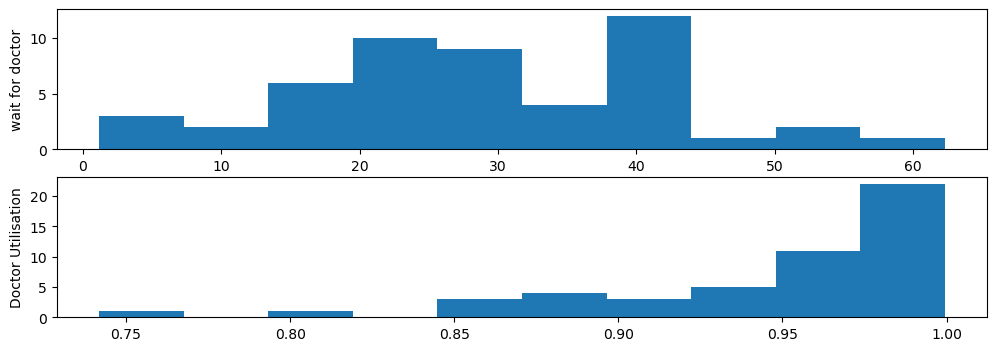

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12,4))
ax[0].hist(results['01_waiting_time']);
ax[0].set_ylabel('wait for doctor')
ax[1].hist(results['03_doctor_util']);
ax[1].set_ylabel('Doctor Utilisation');

## Scenario Analysis

The structured approach we took to organising our `ciw` model allows us to easily experiment with alternative scenarios.  

In [14]:
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario()
    
    # extra doctors
    max_doctors = 5
    for i in range(1, max_doctors+1):
        scenarios[f'doctor+{i}'] = Scenario()
        scenarios[f'doctor+{i}'].n_doctors += i
        
    return scenarios

In [15]:
def run_scenario_analysis(scenarios, n_reps=DEFAULT_N_REPS):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    n_rep: int, optional (default=DEFAULT_N_REPS)
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results = {}
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        replications = multiple_replications(scenario, n_reps=n_reps)
        print('done.\n')
        
        #save the results
        scenario_results[sc_name] = replications
    
    print('Scenario analysis complete.')
    return scenario_results

### Script to run scenario analysis

In [16]:
#get the scenarios
scenarios = get_scenarios()

#run the scenario analysis
scenario_results = run_scenario_analysis(scenarios)

Scenario Analysis
No. Scenario: 6
Replications: 50
Running base => done.

Running doctor+1 => done.

Running doctor+2 => done.

Running doctor+3 => done.

Running doctor+4 => done.

Running doctor+5 => done.

Scenario analysis complete.


In [17]:
def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

In [18]:
# as well as rounding you may want to rename the cols/rows to 
# more readable alternatives.
summary_frame = scenario_summary_frame(scenario_results)
summary_frame.round(2)

,base,doctor+1,doctor+2,doctor+3,doctor+4,doctor+5
00_throughput,45.34,70.38,73.66,72.64,73.04,73.00
01_waiting_time,28.89,4.19,0.71,0.09,0.01,0.00
02_doctor_time,3.02,3.01,3.05,2.99,2.97,2.98
03_doctor_util,0.95,0.76,0.53,0.39,0.31,0.26


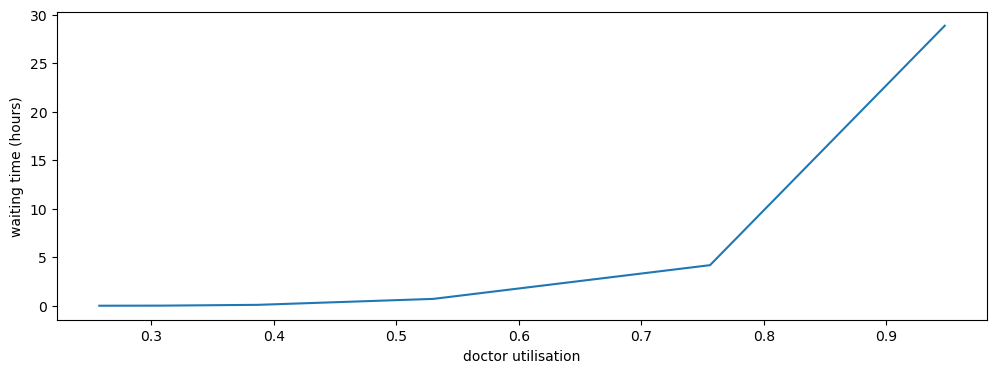

In [19]:
ax = summary_frame.T.plot(y='01_waiting_time', x='03_doctor_util', 
                          figsize=(12,4), legend=False)
ax.set_ylabel('waiting time (hours)')
ax.set_xlabel('doctor utilisation');

## End